# <div align="center"> COSC 2673/2793 | Machine Learning </div>
## <div align="center"> Assignment 2 - Joseph Packham (s3838978) and Kylie Nguyen (s3946026) </div>

# Introduction
This report will cover the process of producing a machine learning model that will predict energy usage...

In [17]:
#importing packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pydot as pyd
from tensorflow.keras.metrics import MeanAbsoluteError

In [ ]:
#read in CSV file and display first 5 rows
energyUse_df = pd.read_csv('./dataset/UCI-electricity/UCI_data.csv', delimiter=',')
energyUse_df.head()

# Exploratory Data Analysis
First, the data is investigated through EDA. It is observed that the shape of the dataframe is 19735 rows of data with 28 columns, where 1 column is the target variable (energy usage in Wh), and the remaining columns are the attributes. According to the description of the data, these attributes cover the temperature and humidity of different rooms in the house, as well as outside, along with a few other weather related variables such as pressure and windspeed. It is noted that there are two variables listed as "Random Variable". Using the .info() function, it is confirmed that there are no null values within the dataset.

In [ ]:
#check for any null values, using shape to compare
print("Shape of Energy Use dataframe: ", energyUse_df.shape, "\n")

energyUse_df.info()

Using the describe function, the count, mean, standard deviation, quantiles and the minimum and maximum values of the data are returned. With these values it is seen that, although the range of the values among the variables regarding humidity and temperature are relatively similar, there are cases where the range differs greatly. For example, the range of Windspeed is between 0-14, whereas the range of target energy is between 10-1110. This suggests that feature scaling should be done later in the process, as the differing ranges may cause problems or confuse the learning algorithms.

In [ ]:
energyUse_df.describe()

# Data distribution
In order to observe the distributions of each variable, histograms are plotted for the variables other than date, as the date variable is of type object and cannot be plotted.

In [ ]:
#get list of columns other than date
columns = (energyUse_df.columns).difference(['date'])
#plot histogram for all variables other than date
plt.figure(figsize=(20,20))
for i, column in enumerate(columns):
    plt.subplot(6,5,i+1)
    plt.hist(energyUse_df[column], alpha=0.3, color='b', density=True)
    plt.title(column)
    plt.xticks(rotation='vertical')
    plt.tight_layout()

> **Observations:**
> - There are a number of attributes that appear to be skewed, eg. RH_5, RH_Out, T2 etc.
> - The two random variables are very evenly distributed.

In [ ]:
#display boxplot for the target, energy usage, variable
plt.boxplot(energyUse_df['TARGET_energy'])
plt.title('Energy Usage')
plt.show()

After displaying the boxplot for the target variable, it is observed that there are a number of outliers above the lower limit. These values will be dropped as to prevent these dramatically different values from affecting the model. The outliers are dropped using the IQR method.

In [ ]:
#get the quantiles and IQR
q1 = energyUse_df['TARGET_energy'].quantile(0.25)
q3 = energyUse_df['TARGET_energy'].quantile(0.75)
IQR = q3-q1

#calculate lower and upper limits
lowerLimit = q1 - (1.5*IQR)
upperLimit = q3 + (1.5*IQR)

#get rid of rows with outliers from the dataframe
energyUse_df = energyUse_df.loc[(energyUse_df['TARGET_energy'] > lowerLimit) & (energyUse_df['TARGET_energy'] < upperLimit)]

#display boxplot without outliers
plt.boxplot(energyUse_df['TARGET_energy'])
plt.title('Energy Usage')
plt.show()

In [ ]:
energyUse_df.shape

# Relationship between variables
Using scatterplots, the relationship between the target variable, Energy Usage, against the other attributes in the dataframe is explored.

In [ ]:
#import seaborn package for plotting scatterplots
import seaborn as sns

#plot scatterplots for all features against target variable
plt.figure(figsize=(20,20))
for i, column in enumerate(columns):
    plt.subplot(6,5, i+1)
    sns.scatterplot(data=energyUse_df, x=column, y='TARGET_energy')
    plt.title(column)

plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [ ]:
#get list of columns other than date and target
columns = (energyUse_df.columns).difference(['date', 'TARGET_energy'])

g = sns.PairGrid(data=energyUse_df, vars=columns, hue='TARGET_energy')
g.map(sns.scatterplot)
plt.show()

> **Observations:**
> - There are some plots that show that a linear decision boundary may be able to separate the two classes. eg. 
> - Whereas there are some plots that show that a non-linear decision boundary may be to separate the two classes. 

In [ ]:
#get df without date column
energyUse_df_noDate = energyUse_df.drop(columns=['date'])

#plot correlation plot
f, ax = plt.subplots(figsize=(11, 9))
corr = energyUse_df_noDate.corr()
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
)

> **Observations:**
> - Variables relating to temperature are highly positively correlated with each other, and variables that are related to humidity are similarly, highly positively correlated with each other.
> - Variables involving temperature generally have either a slight positive, or slight negative correlation with variables involving humidity.
> - RH_6, the humidity outside the building (northside) seems to be quite negatively correlated with variables regarding temperature.
> - The two random variables do not seem to be correlated with any other variable other being highly correlated with themselves as well as each other.

In [ ]:
energyUse_df['TARGET_energy'].hist(figsize=(5,5))
plt.xlabel('Energy Usage')
plt.ylabel('frequency')
plt.show()

# Creating Neural Network

In [24]:
#function to plot learning curve
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name="MeanAbsoluteError"):
    plt.figure(figsize=(10,5))

    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [ ]:
#split the data into traing, testing and validation

with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(energyUse_df, test_size=0.3, shuffle=True, random_state=42)
    test_data, val_data = train_test_split(test_data, test_size=0.5, shuffle=True, random_state=42)

#remove the target column from the data
X_train = train_data.drop(columns=['TARGET_energy', 'date'])
y_train = train_data['TARGET_energy']

X_test = test_data.drop(columns=['TARGET_energy', 'date'])
y_test = test_data['TARGET_energy']

X_val = val_data.drop(columns=['TARGET_energy', 'date'])
y_val = val_data['TARGET_energy']

#train data - used to train the model
#validation data - used to tune the hyperparameters
#test data - used to evaluate the final model






## Base Neural Network on unchanged Data

In [12]:
# base model values
INPUT_DIM = X_train.shape[1]
HIDDEN_LAYER_DIM = 128 #this can be tuned later
OUTPUT_CLASSES = 1

In [16]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(INPUT_DIM,)),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3456      
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [18]:
#compile model
model.compile(optimizer = 'SGD',
              loss = 'mean_squared_error',
              metrics = ['mean_absolute_error'])

In [27]:
#train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=2)


Epoch 1/50
432/432 - 1s - loss: 10780.0859 - mean_absolute_error: 62.4342 - val_loss: 11909.8281 - val_mean_absolute_error: 65.4546 - 523ms/epoch - 1ms/step
Epoch 2/50
432/432 - 0s - loss: 10782.0508 - mean_absolute_error: 62.5084 - val_loss: 11919.0918 - val_mean_absolute_error: 64.3360 - 419ms/epoch - 970us/step
Epoch 3/50
432/432 - 0s - loss: 10780.5557 - mean_absolute_error: 62.3627 - val_loss: 11917.0508 - val_mean_absolute_error: 64.5048 - 435ms/epoch - 1ms/step
Epoch 4/50
432/432 - 0s - loss: 10783.7236 - mean_absolute_error: 62.3032 - val_loss: 11912.0400 - val_mean_absolute_error: 65.0472 - 413ms/epoch - 957us/step
Epoch 5/50
432/432 - 0s - loss: 10781.6230 - mean_absolute_error: 62.4895 - val_loss: 11926.3193 - val_mean_absolute_error: 63.8752 - 490ms/epoch - 1ms/step
Epoch 6/50
432/432 - 1s - loss: 10779.7402 - mean_absolute_error: 62.0760 - val_loss: 11909.1836 - val_mean_absolute_error: 66.1897 - 630ms/epoch - 1ms/step
Epoch 7/50
432/432 - 1s - loss: 10780.8213 - mean_abso

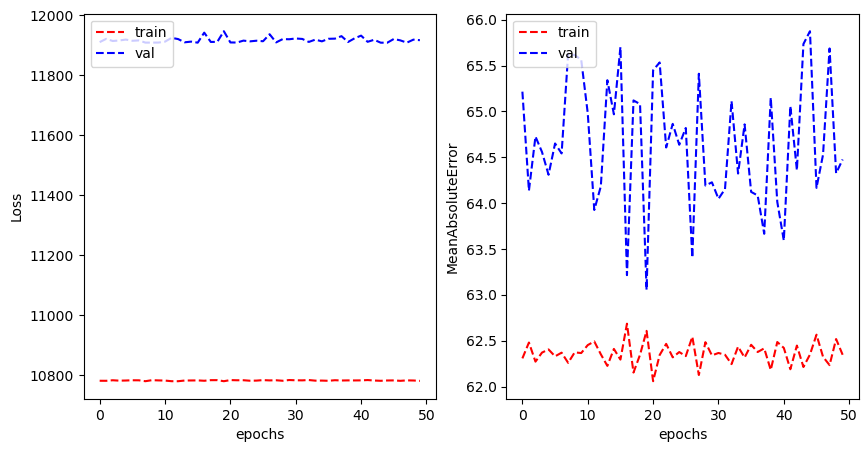

In [25]:

plot_learning_curve(history.history['loss'], history.history['val_loss'],
                    history.history['mean_absolute_error'],
                    history.history['val_mean_absolute_error'])

#### Observations
- the model performs extremely poorly 
- neds significant improvement